In [13]:
pip install torch==2.0.0 torchvision==0.15.1

Note: you may need to restart the kernel to use updated packages.


In [14]:
pip install d2l==1.0.3

Note: you may need to restart the kernel to use updated packages.


In [81]:
import pandas as pd

data = pd.read_csv('METLIN_CCS_vectorfingerprintsVectorized.csv', nrows = 100)
print(data)

adducts = data.iloc[:, 10]

                                        Molecule Name Molecular Formula  \
0   3-[3-(2,3-dihydroindol-1-yl)propyl]-1-[(4-fluo...        C19H22FN3O   
1   3-{[1,1'-biphenyl]-4-ylmethylidene}-6-fluoro-2...        C22H15FO3S   
2   1-{[3-(4-methoxyphenyl)-1,2,4-oxadiazol-5-yl]m...        C25H28N4O3   
3   3-[2-oxo-2-(4-phenylmethanesulfonylpiperazin-1...       C22H30N4O5S   
4   2-{[1,1'-biphenyl]-2-ylamino}-1-(morpholin-4-y...        C18H20N2O2   
..                                                ...               ...   
95  3,3-dimethyl-2-oxobutyl 3-methoxynaphthalene-2...          C18H20O4   
96  N-[1-(adamantan-1-yl)ethyl]-2-(2,5-dioxopyrrol...        C18H26N2O3   
97  N-(4-chlorophenyl)-N-(4-methyl-4,5-dihydro-1,3...     C20H17ClN2O3S   
98  2-oxo-2-(1H-pyrrol-2-yl)ethyl 2,6-difluorobenz...        C13H9F2NO3   
99  2-{[2-(2,3-dihydroindol-1-yl)-2-oxoethyl]sulfa...      C19H17N3O2S2   

    METLIN ID Precursor Adduct    CCS1    CCS2    CCS3  CCS_AVG  % CV  \
0   1181481.0    328.1820[

In [91]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

adduct_types = ['[M+H]', '[M+Na]', '[2M+H]']
encoder = OneHotEncoder(sparse=False, dtype=np.int)
adducts_2d = np.array(adduct_types).reshape(-1, 1)
encoded_adducts = encoder.fit_transform(adducts_2d)
print(encoded_adducts)

adducts_map = {'[M+H]': encoded_adducts[0], '[M+Na]': encoded_adducts[1], '[2M+H]': encoded_adducts[2]}


print(adducts.map(adducts_map))


[[0 1 0]
 [0 0 1]
 [1 0 0]]
0     [0, 1, 0]
1     [0, 1, 0]
2     [0, 1, 0]
3     [0, 1, 0]
4     [0, 1, 0]
        ...    
95    [0, 1, 0]
96    [0, 1, 0]
97    [0, 1, 0]
98    [0, 1, 0]
99    [0, 1, 0]
Name: Adduct, Length: 100, dtype: object


C:\Users\carlo\AppData\Local\Temp\ipykernel_7012\1126320930.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  encoder = OneHotEncoder(sparse=False, dtype=np.int)
C:\Users\carlo\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [107]:
import torch

adduct = torch.tensor(adducts.map(adducts_map))
fingerprints = torch.tensor(data.iloc[:, 21:2235].to_numpy(dtype=int))

data_tensor = torch.cat((adduct, fingerprints), dim=1)
print(data_tensor)

target = torch.tensor(data.iloc[:, 7].to_numpy(dtype=float))


#adduct = adducts.map(adducts_map)
#fingerprints = data.iloc[:, 21:2235].to_numpy(dtype=int)

#target = data.iloc[:, 7].to_numpy(dtype=float)


#print(adduct, fingerprints, target)

tensor([[0, 1, 0,  ..., 0, 1, 0],
        [0, 1, 0,  ..., 0, 1, 0],
        [0, 1, 0,  ..., 0, 1, 1],
        ...,
        [0, 1, 0,  ..., 0, 1, 0],
        [0, 1, 0,  ..., 0, 1, 0],
        [0, 1, 0,  ..., 0, 1, 0]], dtype=torch.int32)


C:\Users\carlo\AppData\Local\Temp\ipykernel_7012\541874628.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32)
C:\Users\carlo\AppData\Local\Temp\ipykernel_7012\541874628.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
C:\Users\carlo\AppData\Local\Temp\ipykernel_7012\541874628.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32)
C:\Users\carlo\AppData\Local\Temp\ipy

MSE: 28347.77
RMSE: 168.37


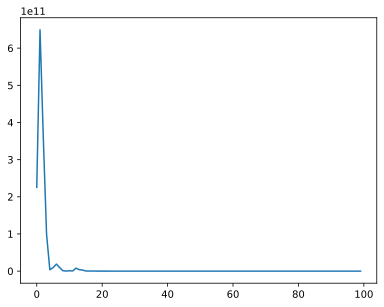

In [114]:
from sklearn.model_selection import train_test_split
import torch.optim as optim
import tqdm
import copy
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(fingerprints, target, train_size=0.7, shuffle=True)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

model = nn.Sequential(
    nn.Linear(2214, 24),
    nn.ReLU(),
    nn.Linear(24, 12),
    nn.ReLU(),
    nn.Linear(12, 6),
    nn.ReLU(),
    nn.Linear(6, 1)
)

loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)

n_epochs = 100   # number of epochs to run
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

best_mse = np.inf   # init to infinity
best_weights = None
history = []

for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())


model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

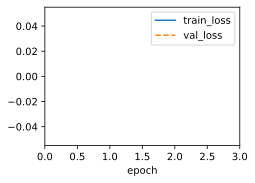

In [111]:
import time
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l
from torch.utils.data import TensorDataset, DataLoader

class MyDataModule(d2l.DataModule):
    def __init__(self, X, y, p_train=0.7): # training data: 70% of dataset
        super().__init__()
        self.save_hyperparameters()
        self.X = X
        self.y = y

    def get_tensorloader(self, tensors, train, indices=slice(0, None)):
        #tensors = tuple(a[indices] for a in tensors)
        dataset = torch.utils.data.TensorDataset(*tensors)
        return torch.utils.data.DataLoader(dataset, shuffle=train)
    
    def get_dataloader(self, train):
        i = slice(0, self.p_train*len(self.X)) if train else slice(self.p_train*len(self.X), None)
        return self.get_tensorloader((self.X, self.y), train, i)


class LinearRegressionScratch(d2l.Module):  #@save
    """The linear regression model implemented from scratch."""
    def __init__(self, num_inputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.w = torch.normal(0, sigma, (num_inputs, 1), requires_grad=True)
        self.b = torch.zeros(1, requires_grad=True)

    def forward(self, X):
        return torch.matmul(X.double(), self.w.double()) + self.b.double()

    def loss(self, y_hat, y):
        l = (y_hat - y) ** 2 / 2
        return l.mean()

    def configure_optimizers(self):
        return SGD([self.w, self.b], self.lr)


class SGD(d2l.HyperParameters):  #@save
    """Minibatch stochastic gradient descent."""
    def __init__(self, params, lr):
        self.save_hyperparameters()

    def step(self):
        for param in self.params:
            param -= self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()


my_data = MyDataModule(data_tensor, target)
model = LinearRegressionScratch(data_tensor.shape[1], lr=0.001)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, my_data)